### 4.3 스케일링

### 조건수

In [5]:
import statsmodels.api as sm
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats

In [4]:
from sklearn.datasets import load_boston

boston = load_boston()

dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)
# join으로 feature_name과 +를 연결
model1 = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 15 May 2020   Prob (F-statistic):          6.72e-135
Time:                        14:58:06   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

```
[2]The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
조건수가 너무큼, 강한 다중공선성이나 다른 수치적 문제가 있을수 있습니다.
```

In [5]:
A = np.eye(4)

In [10]:
b = np.ones(4)
x = sp.linalg.solve(A, b)
x

array([1., 1., 1., 1.])

In [12]:
# A에 오차가 생기면 결과값에도 오차가 발생
x_error = sp.linalg.solve(A + 0.0001 * np.eye(4), b)
x_error

array([0.99990001, 0.99990001, 0.99990001, 0.99990001])

In [14]:
# 4차 힐버트 행렬(Hilbert matrix)이라는 행렬로 조건수가 15000이 넘는다.
A = sp.linalg.hilbert(4)
A

array([[1.        , 0.5       , 0.33333333, 0.25      ],
       [0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.25      , 0.2       , 0.16666667, 0.14285714]])

In [15]:
np.linalg.cond(A)

15513.738738929038

In [16]:
sp.linalg.solve(A, b)

array([  -4.,   60., -180.,  140.])

In [19]:
# 상수벡터에 약간의 오차만 있어도 해가 전혀 다른 값을 가진다
# 위와 완전히 달라진 결과
sp.linalg.solve(A + 0.0001 * np.eye(4), b)

array([ -0.58897672,  21.1225671 , -85.75912499,  78.45650825])

### 회귀분석과 조건수

In [20]:
dfX.describe().loc["std"]
# 표준편차 살펴봄

CRIM         8.601545
ZN          23.322453
INDUS        6.860353
CHAS         0.253994
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          2.105710
RAD          8.707259
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        7.141062
Name: std, dtype: float64

In [21]:
dfX2 = dfX.copy()
dfX2["TAX"] *= 1e13
df2 = pd.concat([dfX2, dfy], axis=1)

model2 = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     83.39
Date:                Fri, 15 May 2020   Prob (F-statistic):           8.62e-44
Time:                        15:57:06   Log-Likelihood:                -1737.9
No. Observations:                 506   AIC:                             3484.
Df Residuals:                     502   BIC:                             3501.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0038      0.000     -8.543      0.0

In [23]:
feature_names = list(boston.feature_names)
feature_names.remove("CHAS") 
# 모두 스케일 작업을 해줌
feature_names = ["scale({})".format(name) for name in feature_names] + ["CHAS"]
model3 = sm.OLS.from_formula("MEDV ~ " + "+".join(feature_names), data=df2)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 15 May 2020   Prob (F-statistic):          6.72e-135
Time:                        15:57:42   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.3470      0.219    101.

### 축소랭크방식

In [24]:
import datetime
from calendar import isleap

def convert_partial_year(number):
    "연 단위 숫자에서 날짜를 계산하는 코드"
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df_nottem = sm.datasets.get_rdataset("nottem").data
df_nottem["date0"] = df_nottem[["time"]].applymap(convert_partial_year)
df_nottem["date"] = pd.DatetimeIndex(df_nottem["date0"]).round('60min') + datetime.timedelta(seconds=3600*24)
df_nottem["month"] = df_nottem["date"].dt.strftime("%m").astype('category')
del df_nottem["date0"], df_nottem["date"]
df_nottem.tail()

,time,value,month
235,1939.583333,61.8,08
236,1939.666667,58.2,09
237,1939.750000,46.7,10
238,1939.833333,46.6,11
239,1939.916667,37.8,12


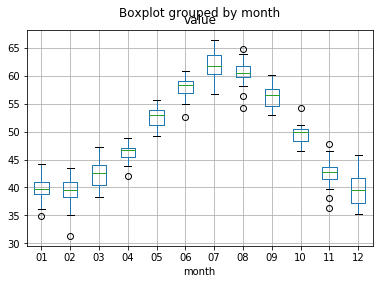

In [27]:
df_nottem.boxplot("value", "month")
plt.show()

In [29]:
# 풀랭크 방식
model = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Fri, 15 May 2020   Prob (F-statistic):          2.96e-125
Time:                        16:32:28   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

In [30]:
# 축소랭크 방식
model = sm.OLS.from_formula("value ~ C(month)", df_nottem)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Fri, 15 May 2020   Prob (F-statistic):          2.96e-125
Time:                        16:33:27   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         39.6950      0.518     76.

In [31]:
# 축소랭크방식을 사용하면 기준이되는 값과 나머지값이 차이가 있는지 없는지를
# 알 수 있음 t검정을 통해
# 이때 귀무가설은 coef=0이다(=기준값과 차이가 없다)

### 보스턴 집값 데이터의 범주형 변수

In [32]:
# 보스턴 집값 축소랭크방식으로
from sklearn.datasets import load_boston

boston = load_boston()

dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df_boston = pd.concat([dfX, dfy], axis=1)

model1 = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_boston)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 15 May 2020   Prob (F-statistic):          6.72e-135
Time:                        16:39:00   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

In [33]:
# 보스턴 집값 풀랭크 방식으로
feature_names = list(boston.feature_names)
feature_names.remove("CHAS") 
feature_names = [name for name in feature_names] + ["C(CHAS)"]
model2 = sm.OLS.from_formula("MEDV ~ 0 + " + "+".join(feature_names), data=df_boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 15 May 2020   Prob (F-statistic):          6.72e-135
Time:                        16:41:04   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(CHAS)[0.0]    36.4595      5.103      7.144   

### 범주형 독립변수와 실수 독립변수의 상호작용

```
범주형 독립변수  x1 과 실수 독립변수  x2 를 가지는 회귀모형에서 
연속값 독립변수  x2 가 미치는 영향 즉 가중치가 
범주형 독립변수  x1 의 값에 따라 달라진다면 
범주형 독립변수를 더미변수  d1 으로 인코딩하고 
연속값 독립변수  x2 는  d1 과의 상호작용 항 d_1:x_2 를 추가하여 사용한다.
```

### 부분회귀 플롯

In [34]:
from sklearn.datasets import load_boston

boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()

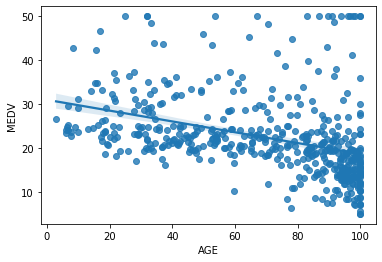

In [38]:
# 음의상관관계처럼 보이나 다른 변수까지 고려하면 음의 상관관계가 아닐수도 있음
sns.regplot(x="AGE", y="MEDV", data=df)
plt.show()

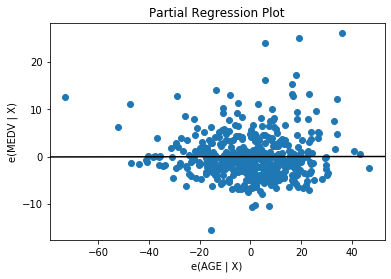

In [40]:
# 부분회귀 플롯으로 살펴보면 AGE 변수와 종속변수는 상관관계가 없다는 것을 알 수 있다.
others = list(set(df.columns).difference(set(["MEDV", "AGE"])))
p, resids = sm.graphics.plot_partregress(
    "MEDV", "AGE", others, data=df, obs_labels=False, ret_coords=True
)
plt.show()

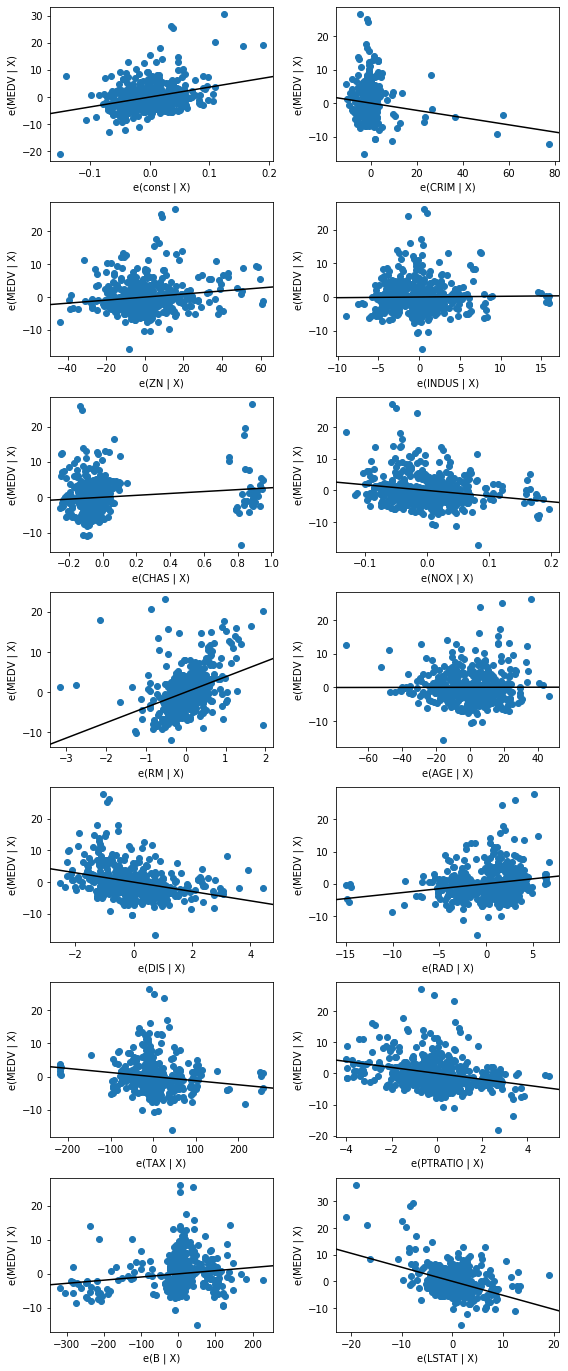

In [42]:
# 모든 변수에 대하여 부분회귀플롯을 그려주는 함수
# 정확한 상관관계를 보여주는
# 항상 부분회귀플롯으로 상관관계를 파악해야함
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result_boston, fig=fig)
fig.suptitle("")
plt.show()

### CCPR

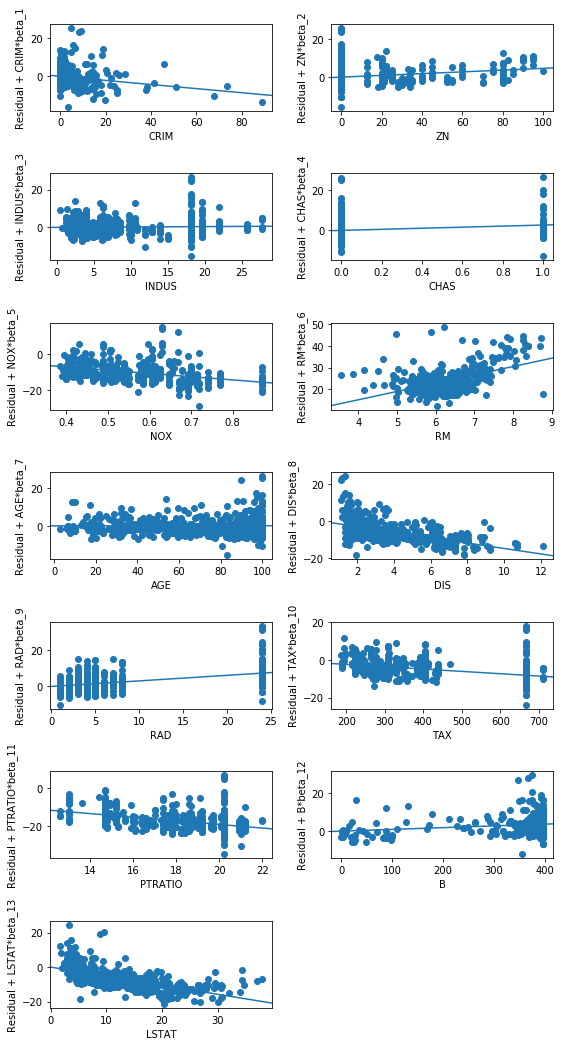

In [44]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(result_boston, fig=fig)
fig.suptitle("")
plt.show()

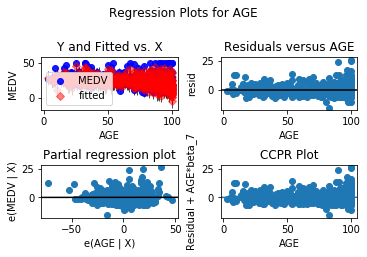

In [46]:
# 부분회귀 플롯과 CCPR을 같이 보여준다.
fig = sm.graphics.plot_regress_exog(result_boston, "AGE")
plt.tight_layout(pad=4, h_pad=0.5, w_pad=0.5)
plt.show()
# 1: 그냥 x와y 음의상관처럼 보임(빨간부분이 예측한 값)
# 2: x와 잔차의플롯(비선형 상관관계 모형이 보이는 경우가 있음->변수변환을 어떻게할지 알 수 있음)
# 3: 부분회귀
# 4: CCPR

### 부트스트래핑

```
모형식 y=w0+w1x+ϵ
모형에 사용된 모수는 상수항이  w0=0
기울기가  w1=42.3855
이라고 데이터 생성
```

In [7]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550486)

In [8]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [9]:
result.params
# 상수항과 기울기에 오차가 있음

const    -1.628364
X1       42.853356
dtype: float64

In [53]:
# 시간이 좀 걸린다는 단점이 있음
%%time
N = 1000 #부트스트래핑 1000번 반복
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
for i in range(N):
    # 데이터 개수(dfy)=100 , 100개에서 100개를 중복허용하여 추출
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

Wall time: 2.08 s


Font 'default' does not have a glyph for '\ucd94' [U+cd94], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc815' [U+c815], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uce58' [U+ce58], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubd84' [U+bd84], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud3ec' [U+d3ec], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ucd94' [U+cd94], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc815' [U+c815], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uce58' [U+ce58], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubd84' [U+bd84], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud3ec' [U+d3ec], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ucd94' [U+cd94], 

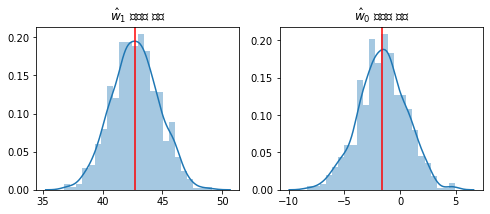

In [54]:
# 부트스트래핑 결과를 플롯으로 -> 불확실성의 범위가 나옴
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("$\hat{w}_1$ 추정치 분포")

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("$\hat{w}_0$ 추정치 분포")
plt.show()

In [55]:
# 편차가 있어도 값이 양수인것은 변함없음
params_w1.mean(), params_w1.std()

(42.72924572753081, 1.9751557414447098)

In [56]:
# 0일 수도 양수일수도 음수일수도 있음
params_w0.mean(), params_w0.std()

(-1.601704352239611, 2.1351522989524225)

In [58]:
# 표준오차 (std err): const와 X1의 가중치인 w에대한 오차
# 위에서 부트스트래핑한것과 같은 의미
# 표준편차의 약 두배만큼하여 신뢰구간도 구해줌
# 확률론적 선형회귀모형을 이용하였기 때문에 부트스트래핑없이도 저런 값이 구해짐
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sat, 16 May 2020   Prob (F-statistic):           2.21e-36
Time:                        23:56:56   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

### 잔차의 분포

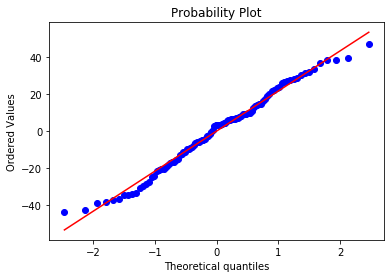

In [10]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()
# 잔차의 qq플롯을 보면 정규분포를 따르는것을 알 수있음

In [12]:
# 정규성 검정
# 옴니버스 노말 테스트
# 귀무가설채택 -> 정규맞음
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [13]:
# 자크베라 테스트
# 귀무가설 채택-> 정규 맞음
test = sm.stats.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


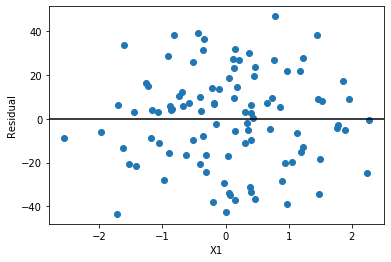

In [15]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

x 가 e에 미치는 영향을 살피기 위해 
0<x<1인 구간과 1<x<2인 구간으로 나누어 e 분포의 모양을 살펴본 것이다. 
둘다 기댓값이 0에 가깝고 분산의 크기가 비슷함

위 그림에서 구간만 똑떼서 본것

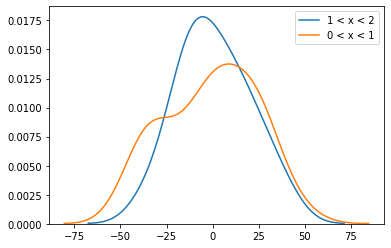

In [17]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()